<a href="https://colab.research.google.com/github/chrischo11/Quant-Investment/blob/main/Timing%2C_Managed_Vol%2C_and_Expected_return_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import datetime as dt
import matplotlib.pyplot as plt
from plotnine import *

### Faber's Timing strategy Backtesting

In [ ]:
russell = pd.read_csv('russell_adjclose.csv',  parse_dates=[0], index_col=[0])
irx = pd.read_csv('^IRX.csv',  parse_dates=[0], index_col=[0])

In [ ]:
#Compute daily return percentage
russell['Ret IWF'] = russell['IWF'].pct_change()
russell['Ret IWD'] = russell['IWD'].pct_change()
russell['Ret IWO'] = russell['IWO'].pct_change()
russell['Ret IWN'] = russell['IWN'].pct_change()

In [ ]:
#Get Tbill yield
russell['Tbill yield'] = irx['Close']
russell['Tbill yield filled'] = russell['Tbill yield'].fillna(method='ffill')

In [ ]:
#Get interval between trading days
russell['dow'] = russell.index.dayofweek
russell['lagdow'] = russell['dow'].shift()
russell['numdays'] = 1
russell.loc[russell['dow'] > (russell['lagdow']+1), 'numdays'] = russell['dow'] - russell['lagdow']
russell.loc[russell['dow'] < russell['lagdow'], 'numdays'] = 3 + russell['dow'] + (4 - russell['lagdow'])
russell.loc['2001-09-17','numdays'] = 7

In [ ]:
russell['Tbill ret'] = russell['Tbill yield filled'].shift() * russell['numdays'] / 365 / 100
russell = russell.drop(['Tbill yield','dow','lagdow'],axis = 1)

In [ ]:
#Compute excess returns
russell['Excess ret IWF'] = russell['Ret IWF'] - russell['Tbill ret']
russell['Excess ret IWD'] = russell['Ret IWD'] - russell['Tbill ret']
russell['Excess ret IWO'] = russell['Ret IWO'] - russell['Tbill ret']
russell['Excess ret IWN'] = russell['Ret IWN'] - russell['Tbill ret']

In [ ]:
#Check status
russell[['Excess ret IWF','Excess ret IWD','Excess ret IWO','Excess ret IWN']].describe()

,Excess ret IWF,Excess ret IWD,Excess ret IWO,Excess ret IWN
count,5574.000000,5574.000000,5574.000000,5574.000000
mean,0.000252,0.000283,0.000280,0.000380
std,0.013201,0.012447,0.016044,0.015184
min,-0.117904,-0.116986,-0.127073,-0.131221
25%,-0.005261,-0.004439,-0.007934,-0.006926
50%,0.000751,0.000656,0.000990,0.000691
75%,0.006306,0.005860,0.008874,0.008037
max,0.123076,0.128289,0.109422,0.094851


In [ ]:
#Compute rolling MA
russell['ma200 IWF'] = russell['IWF'].rolling(200).mean()
russell['ma200 IWD'] = russell['IWD'].rolling(200).mean()
russell['ma200 IWO'] = russell['IWO'].rolling(200).mean()
russell['ma200 IWN'] = russell['IWN'].rolling(200).mean()

In [ ]:
#Decide weight by comparing Adj close prices with MA200 (Both prices from 1 trading day before deciding weight)
russell.loc[russell['IWF'].shift() > russell['ma200 IWF'].shift(), 'weight IWF'] = 0.25
russell.loc[russell['IWF'].shift() < russell['ma200 IWF'].shift(), 'weight IWF'] = 0
russell.loc[russell['IWD'].shift() > russell['ma200 IWD'].shift(), 'weight IWD'] = 0.25
russell.loc[russell['IWD'].shift() < russell['ma200 IWD'].shift(), 'weight IWD'] = 0
russell.loc[russell['IWO'].shift() > russell['ma200 IWO'].shift(), 'weight IWO'] = 0.25
russell.loc[russell['IWO'].shift() < russell['ma200 IWO'].shift(), 'weight IWO'] = 0
russell.loc[russell['IWN'].shift() > russell['ma200 IWN'].shift(), 'weight IWN'] = 0.25
russell.loc[russell['IWN'].shift() < russell['ma200 IWN'].shift(), 'weight IWN'] = 0

In [ ]:
#Compute portfolio1's excess returns
russell['Portfolio1 excess ret'] = (russell['Excess ret IWF'] * russell['weight IWF'] + russell['Excess ret IWD'] * russell['weight IWD'] + russell['Excess ret IWO'] * russell['weight IWO'] + russell['Excess ret IWN'] * russell['weight IWN']) 

The above calculation takes an assumption that the excess return on "cash" is zero. It means that cash is invested at a Risk-free rate, and that we're investing in a unit portfolio. (sum of w = 1) In other words, when we invest less than 100% in the targeted asset, the remaining portion of the portfolio is invested at a Risk-free rate.

In [ ]:
#Compute portfolio2's (Buy and Hold for 25% each) total returns based on weights
russell['Portfolio2 ret'] = (russell['Ret IWF'] * 0.25 + russell['Ret IWD'] * 0.25 + russell['Ret IWO'] * 0.25 + russell['Ret IWN'] * 0.25)

In [ ]:
#Compute portfolio2's excess returns
russell['Portfolio2 excess ret'] = russell['Portfolio2 ret'] - russell['Tbill ret']

In [ ]:
stat1 = russell[['Portfolio1 excess ret']].describe()
stat1

,Portfolio1 excess ret
count,5375.000000
mean,0.000224
std,0.007341
min,-0.043781
25%,-0.002578
50%,0.000000
75%,0.003722
max,0.050407


In [ ]:
stat1.loc['mean']['Portfolio1 excess ret']

0.00022412617105674735

In [ ]:
stat1.loc['mean']['Portfolio1 excess ret'] * 264

0.059169309158981304

In [ ]:
stat1.loc['std']['Portfolio1 excess ret']

0.007341353076471381

In [ ]:
stat1.loc['std']['Portfolio1 excess ret'] * np.sqrt(264)

0.11928286867049173

In [ ]:
SR1 = (stat1.loc['mean']['Portfolio1 excess ret'] * 264) / (stat1.loc['std']['Portfolio1 excess ret'] * np.sqrt(264))
SR1

0.49604196996998146

The Performances of the Portfolio with the strategy's are as follow:
1. Mean: Daily 0.02241%, Annual 5.91693%
2. Standard Deviation: Daily 0.0073414, Annual 0.1192829
3. Sharpe Ratio (Annual basis): 0.496042

In [ ]:
stat2 = russell.iloc[200:][['Portfolio2 excess ret','Portfolio2 ret']].describe()
stat2

,Portfolio2 excess ret,Portfolio2 ret
count,5375.000000,5375.000000
mean,0.000324,0.000373
std,0.013405,0.013403
min,-0.123296,-0.123276
25%,-0.005722,-0.005660
50%,0.000773,0.000847
75%,0.006915,0.006949
max,0.109423,0.109440


In [ ]:
stat2.loc['mean']['Portfolio2 excess ret']

0.00032447753697494887

In [ ]:
stat2.loc['mean']['Portfolio2 excess ret'] * 264

0.0856620697613865

In [ ]:
stat2.loc['std']['Portfolio2 excess ret']

0.013405233672050801

In [ ]:
stat2.loc['std']['Portfolio2 excess ret'] * np.sqrt(264)

0.2178092663497197

In [ ]:
SR2 = (stat2.loc['mean']['Portfolio2 excess ret'] * 264) / (stat2.loc['std']['Portfolio2 excess ret'] * np.sqrt(264))
SR2

0.39328937283983806

The Performances of the Portfolio with Buy and Hold 25% of ETF each are as follow:

1. Mean: Daily 0.03245%, Annual 8.56621%
2. Standard Deviation: Daily 0.0134052, Annual 0.2178093
3. Sharpe Ratio (Annual basis): 0.3932894

Conclusion:
Even though the second portfolio's mean return is higher than that of the first one, The first portfolio's sharpe ratio is higher.

>Additional information (Visualization)

In [ ]:
russell['Strategy'] = (1 + russell['Portfolio1 excess ret']).cumprod()
russell['BuyandHold'] = (1 + russell['Portfolio2 excess ret']).cumprod()

<AxesSubplot:xlabel='Date'>

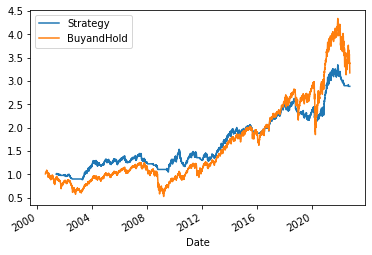

In [ ]:
russell[['Strategy','BuyandHold']].plot()

### Managed Volatility strategy backtesting

In [ ]:
# read csv files
spy = pd.read_csv('SPY.csv',  parse_dates=[0], index_col=[0])
spy = spy[['Adj Close']]
irx = pd.read_csv('^IRX.csv',  parse_dates=[0], index_col=[0])

In [ ]:
# Compute Excess return on SPY
spy['Ret'] = spy['Adj Close'].pct_change()

spy['Tbill yield'] = irx['Close']
spy['Tbill yield filled'] = spy['Tbill yield'].fillna(method='ffill')

spy['DOW'] = spy.index.dayofweek
spy['lag_dow'] = spy['DOW'].shift(1)
spy['Diff'] = spy['DOW'] - spy['lag_dow']

new = spy.loc[spy['Diff']<1][['Diff']]
new['Diff_new'] = new['Diff'] + 7
new.drop(columns=['Diff'], inplace=True)

spy = pd.concat([spy, new.reindex(spy.index)], axis=1)

spy['days'] = spy.loc[:, ['Diff', 'Diff_new']].fillna(0).max(axis=1)

spy = spy[['Adj Close',	'Ret','Tbill yield filled','days']]

spy['Tbill ret'] = spy['Tbill yield filled'].shift(1) * spy['days'] / 36500

spy['Excess ret'] = spy['Ret'] - spy['Tbill ret']

In [ ]:
# Choosing useful columns 
spy = spy[['Adj Close', 'Ret', 'Tbill ret',	'Excess ret']]
spy.head()

,Adj Close,Ret,Tbill ret,Excess ret
Date,,,,
1993-01-29,25.438087,NaN,NaN,NaN
1993-02-01,25.619015,0.007112,0.000238,0.006874
1993-02-02,25.673307,0.002119,0.000079,0.002040
1993-02-03,25.944698,0.010571,0.000081,0.010490
1993-02-04,26.053249,0.004184,0.000080,0.004104


Computing 22 days rolling standard deviation of excess return

In [ ]:
# for example 22 days rolling standard deviation of excess return
spy.iloc[:22]['Excess ret'].std()

0.008267902056160882

In [ ]:
len(spy)

7421

In [ ]:
spy['22_Std'] = np.nan # make a column for 22 rolloing Standard deviation

for t in range(22, len(spy)+1):
    spy_22 = spy.iloc[(t-22):t] # slicing Dataframe from raw 0 to raw 21 (for 22 days) 
    rolling_std = spy_22['Excess ret'].std() # calculating the Standard deviation of each 22 days
    spy['22_Std'].iloc[t-1] = rolling_std # insert the value to spy dataframe

In [ ]:
# check the current status of our dataframe
spy.tail()

,Adj Close,Ret,Tbill ret,Excess ret,22_Std
Date,,,,,
2022-07-13,378.829987,-0.005252,0.000058,-0.005310,0.017332
2022-07-14,377.910004,-0.002428,0.000064,-0.002492,0.016279
2022-07-15,385.130005,0.019105,0.000062,0.019043,0.014576
2022-07-18,381.950012,-0.008257,0.000184,-0.008441,0.014700
2022-07-19,392.269989,0.027019,0.000062,0.026957,0.015469


In [ ]:
# calculating the weight of Managed volatility portfolio
spy['weight'] = 0.01/spy['22_Std'].shift(1)

In [ ]:
# caluating the return of Managed volatilty portfolio
spy['RP'] = spy['weight'] * spy['Ret']

In [ ]:
spy.iloc[18:]

,Adj Close,Ret,Tbill ret,Excess ret,22_Std,weight,RP
Date,,,,,,,
1993-02-25,25.673307,0.002119,0.000081,0.002038,NaN,NaN,NaN
1993-02-26,25.709465,0.001408,0.000081,0.001328,NaN,NaN,NaN
1993-03-01,25.637117,-0.002814,0.000242,-0.003057,NaN,NaN,NaN
1993-03-02,26.017067,0.014820,0.000081,0.014739,0.008268,NaN,NaN
1993-03-03,26.125603,0.004172,0.000081,0.004090,0.008096,1.209497,0.005046
...,...,...,...,...,...,...,...
2022-07-13,378.829987,-0.005252,0.000058,-0.005310,0.017332,0.557994,-0.002930
2022-07-14,377.910004,-0.002428,0.000064,-0.002492,0.016279,0.576959,-0.001401
2022-07-15,385.130005,0.019105,0.000062,0.019043,0.014576,0.614278,0.011736


In [ ]:
# Compare the mean and standard deviation of Managed vol port to a buy and hold position
# We assess these strategies starting from December of 1959, where m(t) exist.
spy.iloc[22:][['RP', 'Ret']].describe()

,RP,Ret
count,7399.000000,7399.000000
mean,0.000503,0.000437
std,0.011068,0.011883
min,-0.083518,-0.109424
25%,-0.005181,-0.004393
50%,0.000887,0.000677
75%,0.006835,0.005917
max,0.055938,0.145198


#### Managed volatility strategy 
 * Daily return mean : 0.0502% 
 * Daily standard deviation : 0.011066 <br>
<br>
#### Buy & Hold strategy
 * Daily return mean : 0.0437%
 * Daily standard deviation : 0.011881

In [ ]:
# Calculating 264-day rolling standard deviations

spy['264_std_port'] = np.nan
spy['264_std_spy'] = np.nan

for t in range(264, len(spy)+1):
    spy_264 = spy.iloc[(t-264):t] 
    std_port = spy_264['RP'].std()
    spy['264_std_port'].iloc[t-1] = std_port
    std_spy = spy_264['Ret'].std()
    spy['264_std_spy'].iloc[t-1] = std_spy

C:\Users\Legion\AppData\Roaming\Python\Python39\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 263 rows containing missing values.
C:\Users\Legion\AppData\Roaming\Python\Python39\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 263 rows containing missing values.


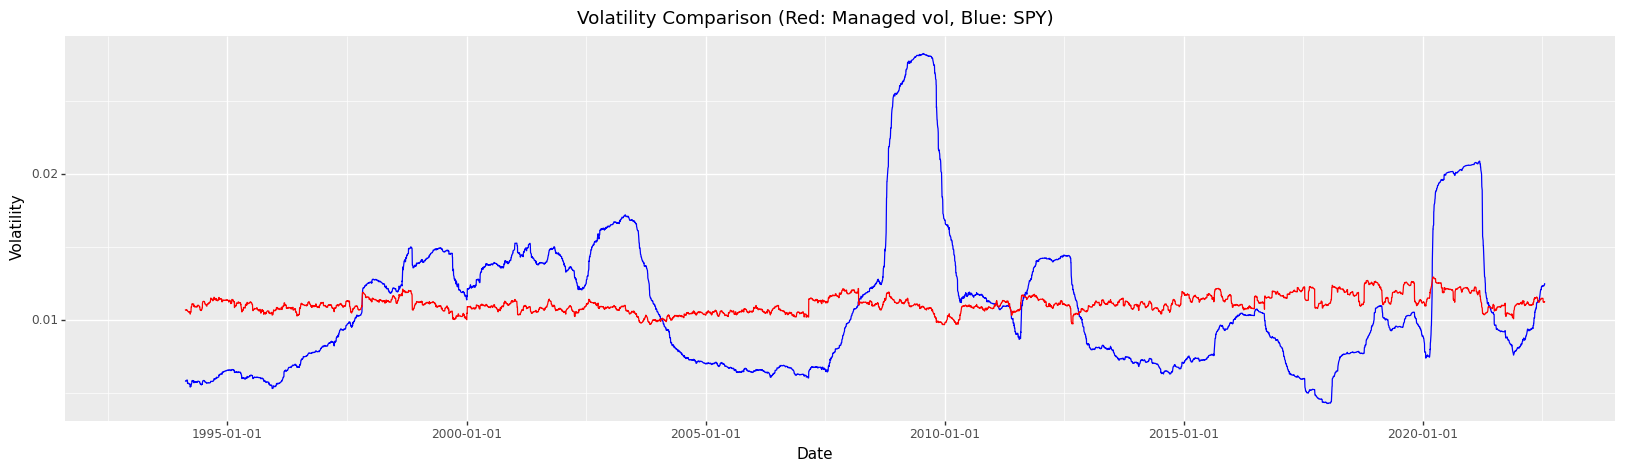

<ggplot: (153663898811)>

In [ ]:
# ploting

spy.reset_index(inplace=True)

(
   ggplot(spy, aes('Date')) + 
   geom_line(aes(y = '264_std_spy'), color='blue') + 
   geom_line(aes(y = '264_std_port'), color = 'red') +
   labs(y = "Volatility", title ="Volatility Comparison (Red: Managed vol, Blue: SPY)") +
   theme(figure_size=(20,5))
) 

### Expected return calculation by using regression model


In [ ]:
df = pd.read_excel('PredictorData2021.xlsx',parse_dates=[0],index_col=[0])
df = df.loc[195001:]
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored


,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx
yyyymm,,,,,,,,,,,,,,,,,
195001,17.05,1.15,2.33667,0.791417,0.0107,0.0257,0.0324,0.0215,0.027102,0.0009,-0.004237,-0.0061,0.0037,0.000989,0.004458,0.019703,0.018245
195002,17.22,1.16,2.35333,0.784998,0.0112,0.0258,0.0324,0.0214,0.025492,0.0009,0.000000,0.0021,0.0007,0.000426,0.004246,0.019603,0.009975
195003,17.29,1.17,2.37000,0.825528,0.0112,0.0258,0.0324,0.0215,0.029291,0.0010,0.004255,0.0008,0.0022,0.000624,0.004553,0.008185,0.003542
195004,18.07,1.18,2.42667,0.796497,0.0115,0.0260,0.0323,0.0214,0.026398,0.0009,0.000000,0.0030,-0.0008,0.000714,0.004022,0.045887,0.044493
195005,18.78,1.19,2.48333,0.761346,0.0116,0.0261,0.0325,0.0213,0.028572,0.0010,0.004237,0.0033,-0.0008,0.000641,0.003803,0.046902,0.037590


In [ ]:
# make columns for variables and extracting useful columns
df['DP'] = df['D12'] / df['Index']
df['TERM'] = df['lty'] - df['tbl']
df['DEF'] = df['BAA'] - df['AAA']
df['excessR'] = df['CRSP_SPvw'] - df['Rfree']
df = df[['DP','TERM','DEF','ntis','excessR']]
df.head()

,DP,TERM,DEF,ntis,excessR
yyyymm,,,,,
195001,0.067449,0.0108,0.0067,0.027102,0.018803
195002,0.067364,0.0102,0.0066,0.025492,0.018703
195003,0.067669,0.0103,0.0066,0.029291,0.007185
195004,0.065302,0.0099,0.0063,0.026398,0.044987
195005,0.063365,0.0097,0.0064,0.028572,0.045902


In [ ]:
# Make reversed shift of excess R (dependent variable) to build a regression.
df['excessR_rshift'] = df['excessR'].shift(-1)

In [ ]:
# Build a regression models and insert m(t) values
df['m(t)'] = np.nan
for t in range(119, len(df)-1):

    dft = df.iloc[(t-119):t] # sling the df for each 119 months
    regout = smf.ols('excessR_rshift ~ DP + TERM + DEF + ntis', data=dft).fit() # make a regression model with variables
    
    df['m(t)'].iloc[t] = regout.params[0] + regout.params[1]*df['DP'].iloc[t] + regout.params[2]*df['TERM'].iloc[t] \
    +regout.params[3]*df['DEF'].iloc[t] + +regout.params[4]*df['ntis'].iloc[t] # insert expected excess return from the model


In [ ]:
# check the current status
df.iloc[117:120]

,DP,TERM,DEF,ntis,excessR,excessR_rshift,m(t)
yyyymm,,,,,,,
195910,0.031583,0.0016,0.0071,0.031020,0.009574,0.015886,NaN
195911,0.031286,0.0017,0.0070,0.029722,0.015886,0.026227,NaN
195912,0.030556,-0.0002,0.0070,0.022856,0.026227,-0.073233,0.000795


In [ ]:
# set the portfolio weight following w(t) = min{1.5, max{0.5, 100*m(t)}}

df['weight'] = 0.5
df.loc[df['m(t)']>0.005, 'weight'] = 100*df['m(t)']
df.loc[df['m(t)']>0.015, 'weight'] = 1.5

In [ ]:
# Thus m(t) means expected return of next month, weight also need to be lagged
# calculate the expected excess return from our model (RP)

df['weight_lag'] = df['weight'].shift()
df['RP'] = df['weight_lag'] * df['excessR']

In [ ]:
# check the current status

df.iloc[119:].head(10)

,DP,TERM,DEF,ntis,excessR,excessR_rshift,m(t),weight,weight_lag,RP
yyyymm,,,,,,,,,,
195912,0.030556,-0.0002,0.0070,0.022856,0.026227,-0.073233,0.000795,0.500000,0.500000,0.013114
196001,0.033567,0.0006,0.0073,0.022116,-0.073233,0.011022,-0.001620,0.500000,0.500000,-0.036616
196002,0.033915,0.0033,0.0078,0.024037,0.011022,-0.016066,0.002149,0.500000,0.500000,0.005511
196003,0.035056,0.0080,0.0076,0.025593,-0.016066,-0.018013,0.006337,0.633692,0.500000,-0.008033
196004,0.035743,0.0103,0.0075,0.025577,-0.018013,0.030813,0.009324,0.932387,0.633692,-0.011415
196005,0.034868,0.0088,0.0082,0.024414,0.030813,0.019402,0.009463,0.946304,0.932387,0.028730
196006,0.034259,0.0161,0.0081,0.024270,0.019402,-0.024248,0.019290,1.500000,0.946304,0.018360
196007,0.035129,0.0152,0.0081,0.025778,-0.024248,0.029767,0.015617,1.500000,1.500000,-0.036372
196008,0.034235,0.0160,0.0080,0.025196,0.029767,-0.060313,0.017492,1.500000,1.500000,0.044651


In [ ]:
# We assess these strategies starting from January of 1960, where m(t) exist.
# comparing mean and standard deviation of both strategies

df.loc[196001:][['excessR','RP']].describe()


,excessR,RP
count,744.000000,744.000000
mean,0.005782,0.006626
std,0.042822,0.041166
min,-0.221795,-0.200103
25%,-0.018287,-0.013748
50%,0.008970,0.005739
75%,0.032270,0.025821
max,0.163013,0.193341


#### Buy & Hold strategy
 * Daily excess return mean : 0.5782% 
 * Daily standard deviation : 0.042822 <br>
<br>
#### Expected return strategy 
 * Daily return mean : 0.6626%
 * Daily standard deviation : 0.041166



In [ ]:
# Calculating sharpe ratio

df.loc[196001:][['excessR','RP']].mean() / df.loc[196001:][['excessR','RP']].std()

excessR    0.135030
RP         0.160946
dtype: float64

Sharpe ratio increased from 0.135 (Buy and hold) to 0.161 (Portfolio).

The above calculation takes an assumption that the excess return on "cash" is zero. It means that cash is invested at a Risk-free rate, and that we're investing in a unit portfolio. (sum of w = 1)

When we invest less than 100% in the asset, the remaining portion of the portfolio is invested at a Risk-free rate.
When we invest more than 100% in the asset, it means that we pay a Risk-free rate.